In [1]:
### Import the required libraries
import numpy as np
import matplotlib.pyplot as plt 

import warnings

warnings.simplefilter("ignore")

import tensorflow as tf
import tensorflow.keras as keras
tf.compat.v1.disable_eager_execution()

import os
import sys

# Append to sys.path the absolute path to src/XAIRT
path_list = os.path.abspath('').split('/')
path_src_XAIRT = ''
for link in path_list[:-1]:
    path_src_XAIRT = path_src_XAIRT+link+'/'
sys.path.append(path_src_XAIRT+'/src')

# Now import module XAIRT
from XAIRT import *

In [2]:
def basal_topology_func(x):
    b = 1.0 - 0.1*x
    return b

def solution(nx, nt, L, T, M, basal_topology_func):

    if len(M) != nx + 1:
        raise ValueError('M specified but len(M) != nx + 1')
        
    dx = L/nx
    dt = T/nt
    x = np.linspace(0,L,nx+1)
    t = np.linspace(0,T,nt+1)

    b = basal_topology_func(x)

    A = 1e-16
    rho = 920.0
    g = 9.2 
    n = 3

    C = 2*A/(n+2) * (rho*g)**n * (1e3)**n

    h = np.zeros((nx+1,nt+1))
    H = np.zeros((nx+1,nt+1))
    h[:,0] = b
    h[0,:] = b[0]
    h[-1,:] = b[-1]

    H[:,0] = h[:,0] - b
    H[0,:] = h[0,:] - b[0]
    H[-1,:] = h[-1,:] - b[-1]

    for i in range(1,len(t)):

        D = C *((H[1:,i-1]+H[:nx,i-1])/2.0)**(n+2) * ((h[1:,i-1] - h[:nx,i-1])/dx)**(n-1)

        phi = -D*(h[1:,i-1]-h[:nx,i-1])/dx

        h[1:nx,i] = h[1:nx,i-1] + M[1:nx]*dt - dt/dx * (phi[1:]-phi[:nx-1])
        h[1:nx,i] = (h[1:nx,i] < b[1:nx]) * b[1:nx] + (h[1:nx,i] >= b[1:nx]) * h[1:nx,i]
        H[:,i] = np.maximum(h[:,i] - b, 0.)

        if not np.any(H[:,i]>=0.0):
            raise Exception("Something went wrong.")
            
    Volume = np.sum(H)*dx
    
    return H[int(nx/2),-1], h[int(nx/2),-1], Volume

L = 30.
T = 10.
nx = 300
nt = 12000
samples = 200

M_samples = 0.01*np.random.rand(samples, nx+1)
H_samples = np.zeros((samples,1), dtype = np.float64)
Volume_samples = np.zeros((samples,1), dtype = np.float64)

for sample in range(samples):
    if (sample+1) % 100 == 0:
        print(f'Sample #{sample+1}', end='\r')
    H_samples[sample], _, Volume_samples[sample] = solution(nx, nt, L, T, M_samples[sample], basal_topology_func)

In [3]:
Layers = [{'size': nx+1, 'activation': None    , 'use_bias': None},
          {'size': 10 , 'activation': 'relu'  , 'use_bias': True},
          {'size': 1  , 'activation': 'linear', 'use_bias': False}]
Losses = [{'kind': 'mse', 'weight': 1.0}]

K = TrainFullyConnected(M_samples, H_samples, 
                    Layers, Losses,
                    'adam', ['mae'], 
                    10, 500, 0.2, 
                    'model', os.path.abspath(''))

best_model = K.quickTrain()

Train on 160 samples, validate on 40 samples
Epoch 1/500
 10/160 [>.............................] - ETA: 1s - loss: 0.0026 - mae: 0.0453

2023-07-03 17:29:34.808261: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/libs/gnu7/openmpi/netcdf/4.5.0/lib:/opt/ohpc/pub/libs/gnu7/openmpi/netcdf-fortran/4.4.4/lib:/opt/ohpc/pub/libs/gnu7/openmpi/hdf5/1.10.1/lib:/opt/ohpc/pub/mpi/openmpi-gnu7/1.10.7/lib:/opt/ohpc/pub/compiler/gcc/7.3.0/lib64:/home/shreyas/lis-1.4.43/installation/lib:/share/jdk-16.0.1/lib::
2023-07-03 17:29:34.808310: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)



Epoch 1: val_loss improved from inf to 0.00047, saving model to /home/shreyas/XAIRT/examples/model.h5
160/160 [==============================] - 0s 1ms/sample - loss: 0.0011 - mae: 0.0280 - val_loss: 4.6743e-04 - val_mae: 0.0189
Epoch 2/500
 10/160 [>.............................] - ETA: 0s - loss: 6.6393e-04 - mae: 0.0225
Epoch 2: val_loss did not improve from 0.00047
160/160 [==============================] - 0s 160us/sample - loss: 5.1891e-04 - mae: 0.0190 - val_loss: 4.8512e-04 - val_mae: 0.0193
Epoch 3/500
 10/160 [>.............................] - ETA: 0s - loss: 4.0028e-04 - mae: 0.0167
Epoch 3: val_loss did not improve from 0.00047
160/160 [==============================] - 0s 166us/sample - loss: 4.8246e-04 - mae: 0.0189 - val_loss: 4.8039e-04 - val_mae: 0.0192
Epoch 4/500
 10/160 [>.............................] - ETA: 0s - loss: 4.3410e-04 - mae: 0.0176
Epoch 4: val_loss did not improve from 0.00047
160/160 [==============================] - 0s 205us/sample - loss: 4.7062e-

Epoch 28/500
 10/160 [>.............................] - ETA: 0s - loss: 2.0436e-04 - mae: 0.0128
Epoch 28: val_loss did not improve from 0.00042
160/160 [==============================] - 0s 189us/sample - loss: 2.5449e-04 - mae: 0.0137 - val_loss: 4.2504e-04 - val_mae: 0.0178
Epoch 29/500
 10/160 [>.............................] - ETA: 0s - loss: 1.3563e-04 - mae: 0.0094
Epoch 29: val_loss improved from 0.00042 to 0.00041, saving model to /home/shreyas/XAIRT/examples/model.h5
160/160 [==============================] - 0s 298us/sample - loss: 2.4511e-04 - mae: 0.0133 - val_loss: 4.1471e-04 - val_mae: 0.0175
Epoch 30/500
 10/160 [>.............................] - ETA: 0s - loss: 2.7386e-04 - mae: 0.0145
Epoch 30: val_loss improved from 0.00041 to 0.00041, saving model to /home/shreyas/XAIRT/examples/model.h5
160/160 [==============================] - 0s 299us/sample - loss: 2.3410e-04 - mae: 0.0129 - val_loss: 4.1164e-04 - val_mae: 0.0173
Epoch 31/500
 10/160 [>.........................

 10/160 [>.............................] - ETA: 0s - loss: 1.1948e-04 - mae: 0.0097
Epoch 56: val_loss did not improve from 0.00039
160/160 [==============================] - 0s 186us/sample - loss: 1.0240e-04 - mae: 0.0084 - val_loss: 3.9578e-04 - val_mae: 0.0171
Epoch 57/500
 10/160 [>.............................] - ETA: 0s - loss: 5.6980e-05 - mae: 0.0066
Epoch 57: val_loss did not improve from 0.00039
160/160 [==============================] - 0s 179us/sample - loss: 9.4793e-05 - mae: 0.0082 - val_loss: 4.3388e-04 - val_mae: 0.0181
Epoch 58/500
 10/160 [>.............................] - ETA: 0s - loss: 1.5068e-04 - mae: 0.0097
Epoch 58: val_loss did not improve from 0.00039
160/160 [==============================] - 0s 167us/sample - loss: 9.6863e-05 - mae: 0.0081 - val_loss: 3.9175e-04 - val_mae: 0.0170
Epoch 59/500
 10/160 [>.............................] - ETA: 0s - loss: 8.9393e-05 - mae: 0.0072
Epoch 59: val_loss did not improve from 0.00039
160/160 [=========================

 10/160 [>.............................] - ETA: 0s - loss: 2.9543e-05 - mae: 0.0046
Epoch 84: val_loss improved from 0.00036 to 0.00036, saving model to /home/shreyas/XAIRT/examples/model.h5
160/160 [==============================] - 0s 363us/sample - loss: 4.4373e-05 - mae: 0.0054 - val_loss: 3.5753e-04 - val_mae: 0.0159
Epoch 85/500
 10/160 [>.............................] - ETA: 0s - loss: 5.5540e-05 - mae: 0.0062
Epoch 85: val_loss did not improve from 0.00036
160/160 [==============================] - 0s 191us/sample - loss: 4.6357e-05 - mae: 0.0056 - val_loss: 3.6099e-04 - val_mae: 0.0160
Epoch 86/500
 10/160 [>.............................] - ETA: 0s - loss: 2.2402e-05 - mae: 0.0043
Epoch 86: val_loss did not improve from 0.00036
160/160 [==============================] - 0s 183us/sample - loss: 4.4237e-05 - mae: 0.0054 - val_loss: 3.6259e-04 - val_mae: 0.0160
Epoch 87/500
 10/160 [>.............................] - ETA: 0s - loss: 4.1425e-05 - mae: 0.0048
Epoch 87: val_loss did 

Epoch 113/500
 10/160 [>.............................] - ETA: 0s - loss: 1.5451e-05 - mae: 0.0033
Epoch 113: val_loss improved from 0.00035 to 0.00035, saving model to /home/shreyas/XAIRT/examples/model.h5
160/160 [==============================] - 0s 360us/sample - loss: 2.3183e-05 - mae: 0.0040 - val_loss: 3.5071e-04 - val_mae: 0.0154
Epoch 114/500
 10/160 [>.............................] - ETA: 0s - loss: 2.0314e-05 - mae: 0.0037
Epoch 114: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 223us/sample - loss: 2.5842e-05 - mae: 0.0041 - val_loss: 3.5725e-04 - val_mae: 0.0157
Epoch 115/500
 10/160 [>.............................] - ETA: 0s - loss: 2.5279e-05 - mae: 0.0044
Epoch 115: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 207us/sample - loss: 2.6211e-05 - mae: 0.0041 - val_loss: 3.7926e-04 - val_mae: 0.0163
Epoch 116/500
 10/160 [>.............................] - ETA: 0s - loss: 8.1944e-06 - mae: 0.0022
Epo

Epoch 142/500
 10/160 [>.............................] - ETA: 0s - loss: 9.6227e-06 - mae: 0.0027
Epoch 142: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 183us/sample - loss: 9.0268e-06 - mae: 0.0024 - val_loss: 3.5512e-04 - val_mae: 0.0157
Epoch 143/500
 10/160 [>.............................] - ETA: 0s - loss: 6.6381e-06 - mae: 0.0022
Epoch 143: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 221us/sample - loss: 9.4222e-06 - mae: 0.0025 - val_loss: 3.6441e-04 - val_mae: 0.0160
Epoch 144/500
 10/160 [>.............................] - ETA: 0s - loss: 1.5481e-05 - mae: 0.0037
Epoch 144: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 203us/sample - loss: 8.2831e-06 - mae: 0.0023 - val_loss: 3.6094e-04 - val_mae: 0.0159
Epoch 145/500
 10/160 [>.............................] - ETA: 0s - loss: 5.3996e-06 - mae: 0.0021
Epoch 145: val_loss did not improve from 0.00035
160/160 [====

 10/160 [>.............................] - ETA: 0s - loss: 1.2991e-06 - mae: 0.0011
Epoch 171: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 163us/sample - loss: 3.7789e-06 - mae: 0.0016 - val_loss: 3.5889e-04 - val_mae: 0.0160
Epoch 172/500
 10/160 [>.............................] - ETA: 0s - loss: 4.5794e-06 - mae: 0.0016
Epoch 172: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 165us/sample - loss: 3.8004e-06 - mae: 0.0015 - val_loss: 3.5919e-04 - val_mae: 0.0160
Epoch 173/500
 10/160 [>.............................] - ETA: 0s - loss: 1.6272e-06 - mae: 0.0011
Epoch 173: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 166us/sample - loss: 3.4575e-06 - mae: 0.0015 - val_loss: 3.6658e-04 - val_mae: 0.0162
Epoch 174/500
 10/160 [>.............................] - ETA: 0s - loss: 3.7467e-06 - mae: 0.0018
Epoch 174: val_loss did not improve from 0.00035
160/160 [==================

 10/160 [>.............................] - ETA: 0s - loss: 1.6699e-06 - mae: 9.8282e-04
Epoch 200: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 161us/sample - loss: 1.5253e-06 - mae: 9.7004e-04 - val_loss: 3.6027e-04 - val_mae: 0.0161
Epoch 201/500
 10/160 [>.............................] - ETA: 0s - loss: 1.2489e-06 - mae: 8.6082e-04
Epoch 201: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 160us/sample - loss: 1.6089e-06 - mae: 9.8456e-04 - val_loss: 3.6655e-04 - val_mae: 0.0163
Epoch 202/500
 10/160 [>.............................] - ETA: 0s - loss: 1.4085e-06 - mae: 0.0010
Epoch 202: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 166us/sample - loss: 1.3565e-06 - mae: 9.1580e-04 - val_loss: 3.6446e-04 - val_mae: 0.0162
Epoch 203/500
 10/160 [>.............................] - ETA: 0s - loss: 1.1950e-06 - mae: 9.0752e-04
Epoch 203: val_loss did not improve from 0.00035
160

Epoch 229/500
 10/160 [>.............................] - ETA: 0s - loss: 8.3037e-07 - mae: 7.3414e-04
Epoch 229: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 157us/sample - loss: 5.3032e-07 - mae: 5.6699e-04 - val_loss: 3.6604e-04 - val_mae: 0.0163
Epoch 230/500
 10/160 [>.............................] - ETA: 0s - loss: 2.5485e-07 - mae: 3.9977e-04
Epoch 230: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 158us/sample - loss: 7.3980e-07 - mae: 7.2275e-04 - val_loss: 3.6279e-04 - val_mae: 0.0162
Epoch 231/500
 10/160 [>.............................] - ETA: 0s - loss: 1.1209e-07 - mae: 2.4402e-04
Epoch 231: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 159us/sample - loss: 6.2712e-07 - mae: 6.3253e-04 - val_loss: 3.6434e-04 - val_mae: 0.0163
Epoch 232/500
 10/160 [>.............................] - ETA: 0s - loss: 3.2674e-07 - mae: 4.8586e-04
Epoch 232: val_loss did not improv

160/160 [==============================] - 0s 130us/sample - loss: 1.9396e-07 - mae: 3.5184e-04 - val_loss: 3.6265e-04 - val_mae: 0.0162
Epoch 258/500
 10/160 [>.............................] - ETA: 0s - loss: 2.9438e-07 - mae: 4.1098e-04
Epoch 258: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 133us/sample - loss: 2.0714e-07 - mae: 3.6481e-04 - val_loss: 3.6273e-04 - val_mae: 0.0162
Epoch 259/500
 10/160 [>.............................] - ETA: 0s - loss: 3.1015e-07 - mae: 4.8784e-04
Epoch 259: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 132us/sample - loss: 1.5549e-07 - mae: 3.2086e-04 - val_loss: 3.6574e-04 - val_mae: 0.0163
Epoch 260/500
 10/160 [>.............................] - ETA: 0s - loss: 1.0561e-07 - mae: 2.9387e-04
Epoch 260: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 138us/sample - loss: 1.4929e-07 - mae: 3.0534e-04 - val_loss: 3.6518e-04 - val_mae: 0.0163

Epoch 286/500
 10/160 [>.............................] - ETA: 0s - loss: 2.2045e-08 - mae: 1.1530e-04
Epoch 286: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 174us/sample - loss: 9.1735e-08 - mae: 2.4392e-04 - val_loss: 3.6433e-04 - val_mae: 0.0162
Epoch 287/500
 10/160 [>.............................] - ETA: 0s - loss: 1.3561e-07 - mae: 2.8699e-04
Epoch 287: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 173us/sample - loss: 7.1046e-08 - mae: 2.0933e-04 - val_loss: 3.6638e-04 - val_mae: 0.0163
Epoch 288/500
 10/160 [>.............................] - ETA: 0s - loss: 6.2262e-08 - mae: 1.9743e-04
Epoch 288: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 168us/sample - loss: 6.0650e-08 - mae: 1.9363e-04 - val_loss: 3.6714e-04 - val_mae: 0.0163
Epoch 289/500
 10/160 [>.............................] - ETA: 0s - loss: 5.1156e-08 - mae: 2.0036e-04
Epoch 289: val_loss did not improv

160/160 [==============================] - 0s 164us/sample - loss: 1.9456e-08 - mae: 1.0963e-04 - val_loss: 3.6644e-04 - val_mae: 0.0163
Epoch 315/500
 10/160 [>.............................] - ETA: 0s - loss: 1.1769e-08 - mae: 9.3841e-05
Epoch 315: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 163us/sample - loss: 1.2224e-08 - mae: 8.7561e-05 - val_loss: 3.6638e-04 - val_mae: 0.0163
Epoch 316/500
 10/160 [>.............................] - ETA: 0s - loss: 1.2071e-08 - mae: 8.4477e-05
Epoch 316: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 162us/sample - loss: 1.3325e-08 - mae: 9.2159e-05 - val_loss: 3.6786e-04 - val_mae: 0.0163
Epoch 317/500
 10/160 [>.............................] - ETA: 0s - loss: 1.4278e-08 - mae: 9.2572e-05
Epoch 317: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 159us/sample - loss: 1.4685e-08 - mae: 9.7487e-05 - val_loss: 3.6733e-04 - val_mae: 0.0163

Epoch 343/500
 10/160 [>.............................] - ETA: 0s - loss: 1.3532e-08 - mae: 1.0877e-04
Epoch 343: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 182us/sample - loss: 7.7749e-09 - mae: 7.3425e-05 - val_loss: 3.6813e-04 - val_mae: 0.0163
Epoch 344/500
 10/160 [>.............................] - ETA: 0s - loss: 5.8020e-09 - mae: 6.8310e-05
Epoch 344: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 205us/sample - loss: 5.0776e-09 - mae: 5.5429e-05 - val_loss: 3.6754e-04 - val_mae: 0.0163
Epoch 345/500
 10/160 [>.............................] - ETA: 0s - loss: 1.0495e-09 - mae: 2.4511e-05
Epoch 345: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 201us/sample - loss: 2.7925e-09 - mae: 4.2429e-05 - val_loss: 3.6732e-04 - val_mae: 0.0163
Epoch 346/500
 10/160 [>.............................] - ETA: 0s - loss: 9.6976e-10 - mae: 2.5428e-05
Epoch 346: val_loss did not improv

160/160 [==============================] - 0s 146us/sample - loss: 1.0642e-09 - mae: 2.6728e-05 - val_loss: 3.6794e-04 - val_mae: 0.0163
Epoch 372/500
 10/160 [>.............................] - ETA: 0s - loss: 9.7110e-10 - mae: 2.5867e-05
Epoch 372: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 152us/sample - loss: 5.4742e-10 - mae: 1.8297e-05 - val_loss: 3.6749e-04 - val_mae: 0.0163
Epoch 373/500
 10/160 [>.............................] - ETA: 0s - loss: 8.3263e-10 - mae: 2.6144e-05
Epoch 373: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 155us/sample - loss: 1.0412e-09 - mae: 2.5617e-05 - val_loss: 3.6797e-04 - val_mae: 0.0163
Epoch 374/500
 10/160 [>.............................] - ETA: 0s - loss: 1.4800e-09 - mae: 3.7121e-05
Epoch 374: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 154us/sample - loss: 8.5683e-10 - mae: 2.3508e-05 - val_loss: 3.6744e-04 - val_mae: 0.0163

Epoch 400/500
 10/160 [>.............................] - ETA: 0s - loss: 1.4704e-10 - mae: 1.0337e-05
Epoch 400: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 198us/sample - loss: 2.5510e-10 - mae: 1.3217e-05 - val_loss: 3.6760e-04 - val_mae: 0.0163
Epoch 401/500
 10/160 [>.............................] - ETA: 0s - loss: 2.5755e-10 - mae: 1.3845e-05
Epoch 401: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 210us/sample - loss: 3.5375e-10 - mae: 1.6607e-05 - val_loss: 3.6756e-04 - val_mae: 0.0163
Epoch 402/500
 10/160 [>.............................] - ETA: 0s - loss: 8.2407e-10 - mae: 2.7422e-05
Epoch 402: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 217us/sample - loss: 2.7695e-10 - mae: 1.3653e-05 - val_loss: 3.6774e-04 - val_mae: 0.0163
Epoch 403/500
 10/160 [>.............................] - ETA: 0s - loss: 5.6009e-11 - mae: 5.8170e-06
Epoch 403: val_loss did not improv

160/160 [==============================] - 0s 148us/sample - loss: 1.0703e-10 - mae: 8.4226e-06 - val_loss: 3.6780e-04 - val_mae: 0.0163
Epoch 429/500
 10/160 [>.............................] - ETA: 0s - loss: 3.0113e-11 - mae: 4.7531e-06
Epoch 429: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 153us/sample - loss: 3.4729e-11 - mae: 4.7107e-06 - val_loss: 3.6780e-04 - val_mae: 0.0163
Epoch 430/500
 10/160 [>.............................] - ETA: 0s - loss: 7.4985e-12 - mae: 2.1387e-06
Epoch 430: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 162us/sample - loss: 4.3366e-11 - mae: 5.3319e-06 - val_loss: 3.6777e-04 - val_mae: 0.0163
Epoch 431/500
 10/160 [>.............................] - ETA: 0s - loss: 3.4037e-11 - mae: 4.9404e-06
Epoch 431: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 159us/sample - loss: 1.1415e-10 - mae: 9.1363e-06 - val_loss: 3.6772e-04 - val_mae: 0.0163

Epoch 457/500
 10/160 [>.............................] - ETA: 0s - loss: 4.1439e-07 - mae: 5.9765e-04
Epoch 457: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 138us/sample - loss: 1.3314e-07 - mae: 2.9259e-04 - val_loss: 3.6807e-04 - val_mae: 0.0163
Epoch 458/500
 10/160 [>.............................] - ETA: 0s - loss: 1.2241e-07 - mae: 2.8078e-04
Epoch 458: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 133us/sample - loss: 8.5438e-08 - mae: 2.4219e-04 - val_loss: 3.6722e-04 - val_mae: 0.0163
Epoch 459/500
 10/160 [>.............................] - ETA: 0s - loss: 2.7858e-08 - mae: 1.4266e-04
Epoch 459: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 131us/sample - loss: 1.6450e-07 - mae: 3.3870e-04 - val_loss: 3.6720e-04 - val_mae: 0.0163
Epoch 460/500
 10/160 [>.............................] - ETA: 0s - loss: 9.0063e-09 - mae: 7.6388e-05
Epoch 460: val_loss did not improv

160/160 [==============================] - 0s 118us/sample - loss: 1.0116e-07 - mae: 2.6071e-04 - val_loss: 3.6980e-04 - val_mae: 0.0163
Epoch 486/500
 10/160 [>.............................] - ETA: 0s - loss: 5.2308e-08 - mae: 2.0214e-04
Epoch 486: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 122us/sample - loss: 5.0763e-07 - mae: 6.0939e-04 - val_loss: 3.8034e-04 - val_mae: 0.0165
Epoch 487/500
 10/160 [>.............................] - ETA: 0s - loss: 1.2226e-06 - mae: 0.0011
Epoch 487: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 126us/sample - loss: 6.0937e-07 - mae: 6.4269e-04 - val_loss: 3.6010e-04 - val_mae: 0.0161
Epoch 488/500
 10/160 [>.............................] - ETA: 0s - loss: 1.6541e-06 - mae: 0.0012
Epoch 488: val_loss did not improve from 0.00035
160/160 [==============================] - 0s 123us/sample - loss: 7.7499e-07 - mae: 7.3573e-04 - val_loss: 3.7031e-04 - val_mae: 0.0163
Epoch 4

In [4]:
normalizeDict = {'bool_':True, 'kind': 'MaxAbs'}
kwargs = {'y_ref': 0.001}
X = XAIR(best_model, 'lrp.z', 'letzgus', M_samples[:10], normalizeDict, **kwargs)
X.check_sample(M_samples[0]), X.check_sample(M_samples[10])

(array([[-2.7527916e-05]], dtype=float32),
 array([[-3.270607e-05]], dtype=float32))

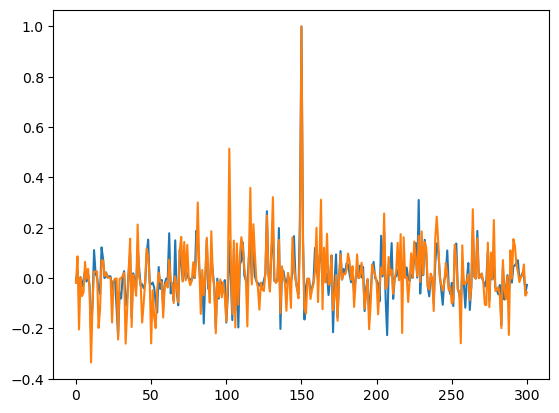

In [5]:
a, stats  = X.quick_analyze()
plt.plot(a[0])
plt.plot(a[1])

In [6]:
best_model = K.quickTrain()
normalizeDict = {'bool_':True, 'kind': 'MaxAbs'}
kwargs = {'y_ref': 0.001}
X = XAIR(best_model, 'lrp.z', 'classic', M_samples[:10], normalizeDict, **kwargs)
X.check_sample(M_samples[0]), X.check_sample(M_samples[10])

Train on 160 samples, validate on 40 samples
Epoch 1/500
 10/160 [>.............................] - ETA: 0s - loss: 0.0028 - mae: 0.0471
Epoch 1: val_loss improved from inf to 0.00128, saving model to /home/shreyas/XAIRT/examples/model.h5
160/160 [==============================] - 0s 1ms/sample - loss: 0.0023 - mae: 0.0425 - val_loss: 0.0013 - val_mae: 0.0308
Epoch 2/500
 10/160 [>.............................] - ETA: 0s - loss: 8.1530e-04 - mae: 0.0225
Epoch 2: val_loss improved from 0.00128 to 0.00045, saving model to /home/shreyas/XAIRT/examples/model.h5
160/160 [==============================] - 0s 354us/sample - loss: 6.6303e-04 - mae: 0.0213 - val_loss: 4.5029e-04 - val_mae: 0.0178
Epoch 3/500
 10/160 [>.............................] - ETA: 0s - loss: 3.9235e-04 - mae: 0.0162
Epoch 3: val_loss did not improve from 0.00045
160/160 [==============================] - 0s 218us/sample - loss: 5.1376e-04 - mae: 0.0186 - val_loss: 4.6187e-04 - val_mae: 0.0177
Epoch 4/500
 10/160 [>.....

Epoch 26/500
 10/160 [>.............................] - ETA: 0s - loss: 5.2193e-04 - mae: 0.0205
Epoch 26: val_loss did not improve from 0.00040
160/160 [==============================] - 0s 187us/sample - loss: 3.5374e-04 - mae: 0.0160 - val_loss: 4.0289e-04 - val_mae: 0.0168
Epoch 27/500
 10/160 [>.............................] - ETA: 0s - loss: 2.5786e-04 - mae: 0.0141
Epoch 27: val_loss did not improve from 0.00040
160/160 [==============================] - 0s 206us/sample - loss: 3.5732e-04 - mae: 0.0157 - val_loss: 4.0378e-04 - val_mae: 0.0173
Epoch 28/500
 10/160 [>.............................] - ETA: 0s - loss: 3.6318e-04 - mae: 0.0169
Epoch 28: val_loss improved from 0.00040 to 0.00040, saving model to /home/shreyas/XAIRT/examples/model.h5
160/160 [==============================] - 0s 397us/sample - loss: 3.3978e-04 - mae: 0.0157 - val_loss: 4.0058e-04 - val_mae: 0.0167
Epoch 29/500
 10/160 [>.............................] - ETA: 0s - loss: 3.5833e-04 - mae: 0.0169
Epoch 29: 

 10/160 [>.............................] - ETA: 0s - loss: 1.0335e-04 - mae: 0.0094
Epoch 52: val_loss did not improve from 0.00036
160/160 [==============================] - 0s 272us/sample - loss: 1.8401e-04 - mae: 0.0112 - val_loss: 3.6090e-04 - val_mae: 0.0159
Epoch 53/500
 10/160 [>.............................] - ETA: 0s - loss: 1.3218e-04 - mae: 0.0107
Epoch 53: val_loss did not improve from 0.00036
160/160 [==============================] - 0s 202us/sample - loss: 1.7768e-04 - mae: 0.0110 - val_loss: 3.6102e-04 - val_mae: 0.0159
Epoch 54/500
 10/160 [>.............................] - ETA: 0s - loss: 1.7710e-04 - mae: 0.0117
Epoch 54: val_loss improved from 0.00036 to 0.00035, saving model to /home/shreyas/XAIRT/examples/model.h5
160/160 [==============================] - 0s 346us/sample - loss: 1.7267e-04 - mae: 0.0108 - val_loss: 3.5491e-04 - val_mae: 0.0156
Epoch 55/500
 10/160 [>.............................] - ETA: 0s - loss: 2.4762e-04 - mae: 0.0134
Epoch 55: val_loss impr

Epoch 80/500
 10/160 [>.............................] - ETA: 0s - loss: 9.7022e-05 - mae: 0.0070
Epoch 80: val_loss did not improve from 0.00034
160/160 [==============================] - 0s 197us/sample - loss: 7.6649e-05 - mae: 0.0070 - val_loss: 3.4252e-04 - val_mae: 0.0150
Epoch 81/500
 10/160 [>.............................] - ETA: 0s - loss: 1.0585e-04 - mae: 0.0095
Epoch 81: val_loss did not improve from 0.00034
160/160 [==============================] - 0s 212us/sample - loss: 7.6972e-05 - mae: 0.0071 - val_loss: 3.5893e-04 - val_mae: 0.0156
Epoch 82/500
 10/160 [>.............................] - ETA: 0s - loss: 5.1284e-05 - mae: 0.0051
Epoch 82: val_loss did not improve from 0.00034
160/160 [==============================] - 0s 210us/sample - loss: 7.4807e-05 - mae: 0.0069 - val_loss: 3.4988e-04 - val_mae: 0.0153
Epoch 83/500
 10/160 [>.............................] - ETA: 0s - loss: 4.2885e-05 - mae: 0.0052
Epoch 83: val_loss improved from 0.00034 to 0.00033, saving model to 

Epoch 108/500
 10/160 [>.............................] - ETA: 0s - loss: 3.3639e-05 - mae: 0.0052
Epoch 108: val_loss did not improve from 0.00033
160/160 [==============================] - 0s 216us/sample - loss: 3.8685e-05 - mae: 0.0050 - val_loss: 3.2974e-04 - val_mae: 0.0143
Epoch 109/500
 10/160 [>.............................] - ETA: 0s - loss: 6.2531e-05 - mae: 0.0057
Epoch 109: val_loss did not improve from 0.00033
160/160 [==============================] - 0s 225us/sample - loss: 4.0646e-05 - mae: 0.0051 - val_loss: 3.4596e-04 - val_mae: 0.0152
Epoch 110/500
 10/160 [>.............................] - ETA: 0s - loss: 4.0691e-05 - mae: 0.0059
Epoch 110: val_loss did not improve from 0.00033
160/160 [==============================] - 0s 207us/sample - loss: 3.8587e-05 - mae: 0.0050 - val_loss: 3.3822e-04 - val_mae: 0.0149
Epoch 111/500
 10/160 [>.............................] - ETA: 0s - loss: 1.8923e-05 - mae: 0.0035
Epoch 111: val_loss did not improve from 0.00033
160/160 [====

160/160 [==============================] - 0s 424us/sample - loss: 2.0669e-05 - mae: 0.0037 - val_loss: 3.2540e-04 - val_mae: 0.0144
Epoch 137/500
 10/160 [>.............................] - ETA: 0s - loss: 2.0431e-05 - mae: 0.0035
Epoch 137: val_loss improved from 0.00033 to 0.00032, saving model to /home/shreyas/XAIRT/examples/model.h5
160/160 [==============================] - 0s 340us/sample - loss: 2.2093e-05 - mae: 0.0038 - val_loss: 3.2447e-04 - val_mae: 0.0144
Epoch 138/500
 10/160 [>.............................] - ETA: 0s - loss: 1.0554e-05 - mae: 0.0023
Epoch 138: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 178us/sample - loss: 2.2375e-05 - mae: 0.0036 - val_loss: 3.2722e-04 - val_mae: 0.0145
Epoch 139/500
 10/160 [>.............................] - ETA: 0s - loss: 2.3059e-05 - mae: 0.0038
Epoch 139: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 198us/sample - loss: 1.9115e-05 - mae: 0.0035 - val_los

Epoch 166/500
 10/160 [>.............................] - ETA: 0s - loss: 9.9017e-06 - mae: 0.0027
Epoch 166: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 166us/sample - loss: 1.0635e-05 - mae: 0.0026 - val_loss: 3.3176e-04 - val_mae: 0.0148
Epoch 167/500
 10/160 [>.............................] - ETA: 0s - loss: 6.3490e-06 - mae: 0.0022
Epoch 167: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 166us/sample - loss: 9.5659e-06 - mae: 0.0025 - val_loss: 3.4178e-04 - val_mae: 0.0152
Epoch 168/500
 10/160 [>.............................] - ETA: 0s - loss: 8.5108e-06 - mae: 0.0024
Epoch 168: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 173us/sample - loss: 1.0922e-05 - mae: 0.0026 - val_loss: 3.3649e-04 - val_mae: 0.0150
Epoch 169/500
 10/160 [>.............................] - ETA: 0s - loss: 3.8287e-06 - mae: 0.0017
Epoch 169: val_loss did not improve from 0.00032
160/160 [====

 10/160 [>.............................] - ETA: 0s - loss: 4.1761e-06 - mae: 0.0017
Epoch 195: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 174us/sample - loss: 4.7665e-06 - mae: 0.0017 - val_loss: 3.4124e-04 - val_mae: 0.0152
Epoch 196/500
 10/160 [>.............................] - ETA: 0s - loss: 3.0113e-06 - mae: 0.0015
Epoch 196: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 167us/sample - loss: 4.6459e-06 - mae: 0.0017 - val_loss: 3.4087e-04 - val_mae: 0.0152
Epoch 197/500
 10/160 [>.............................] - ETA: 0s - loss: 5.9030e-06 - mae: 0.0020
Epoch 197: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 171us/sample - loss: 4.7096e-06 - mae: 0.0017 - val_loss: 3.4173e-04 - val_mae: 0.0152
Epoch 198/500
 10/160 [>.............................] - ETA: 0s - loss: 3.9542e-06 - mae: 0.0018
Epoch 198: val_loss did not improve from 0.00032
160/160 [==================

 10/160 [>.............................] - ETA: 0s - loss: 1.4329e-06 - mae: 9.0651e-04
Epoch 224: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 157us/sample - loss: 3.0011e-06 - mae: 0.0013 - val_loss: 3.4523e-04 - val_mae: 0.0154
Epoch 225/500
 10/160 [>.............................] - ETA: 0s - loss: 1.0189e-06 - mae: 8.2339e-04
Epoch 225: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 158us/sample - loss: 2.6834e-06 - mae: 0.0013 - val_loss: 3.4061e-04 - val_mae: 0.0153
Epoch 226/500
 10/160 [>.............................] - ETA: 0s - loss: 6.5305e-06 - mae: 0.0022
Epoch 226: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 164us/sample - loss: 2.8827e-06 - mae: 0.0014 - val_loss: 3.4588e-04 - val_mae: 0.0154
Epoch 227/500
 10/160 [>.............................] - ETA: 0s - loss: 2.2098e-06 - mae: 0.0013
Epoch 227: val_loss did not improve from 0.00032
160/160 [==========

Epoch 253/500
 10/160 [>.............................] - ETA: 0s - loss: 1.9731e-06 - mae: 0.0011
Epoch 253: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 185us/sample - loss: 1.3359e-06 - mae: 9.1906e-04 - val_loss: 3.4810e-04 - val_mae: 0.0155
Epoch 254/500
 10/160 [>.............................] - ETA: 0s - loss: 5.6743e-07 - mae: 6.2447e-04
Epoch 254: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 208us/sample - loss: 1.1457e-06 - mae: 8.2445e-04 - val_loss: 3.4659e-04 - val_mae: 0.0155
Epoch 255/500
 10/160 [>.............................] - ETA: 0s - loss: 5.1604e-07 - mae: 4.9941e-04
Epoch 255: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 198us/sample - loss: 9.9223e-07 - mae: 8.0504e-04 - val_loss: 3.4922e-04 - val_mae: 0.0155
Epoch 256/500
 10/160 [>.............................] - ETA: 0s - loss: 1.3511e-06 - mae: 0.0010
Epoch 256: val_loss did not improve from 0

160/160 [==============================] - 0s 153us/sample - loss: 5.0991e-07 - mae: 5.7427e-04 - val_loss: 3.4822e-04 - val_mae: 0.0156
Epoch 282/500
 10/160 [>.............................] - ETA: 0s - loss: 7.8208e-07 - mae: 7.0312e-04
Epoch 282: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 154us/sample - loss: 4.8495e-07 - mae: 5.4331e-04 - val_loss: 3.4918e-04 - val_mae: 0.0156
Epoch 283/500
 10/160 [>.............................] - ETA: 0s - loss: 2.9816e-07 - mae: 4.3164e-04
Epoch 283: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 145us/sample - loss: 5.2325e-07 - mae: 5.6749e-04 - val_loss: 3.4836e-04 - val_mae: 0.0156
Epoch 284/500
 10/160 [>.............................] - ETA: 0s - loss: 6.6448e-07 - mae: 6.7251e-04
Epoch 284: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 150us/sample - loss: 4.3677e-07 - mae: 5.2280e-04 - val_loss: 3.5101e-04 - val_mae: 0.0156

Epoch 310/500
 10/160 [>.............................] - ETA: 0s - loss: 1.1290e-07 - mae: 2.7621e-04
Epoch 310: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 177us/sample - loss: 2.3690e-07 - mae: 4.0134e-04 - val_loss: 3.5120e-04 - val_mae: 0.0156
Epoch 311/500
 10/160 [>.............................] - ETA: 0s - loss: 1.9200e-07 - mae: 3.6543e-04
Epoch 311: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 188us/sample - loss: 1.5307e-07 - mae: 3.1623e-04 - val_loss: 3.5167e-04 - val_mae: 0.0156
Epoch 312/500
 10/160 [>.............................] - ETA: 0s - loss: 8.1961e-08 - mae: 2.5700e-04
Epoch 312: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 174us/sample - loss: 1.9016e-07 - mae: 3.5903e-04 - val_loss: 3.5126e-04 - val_mae: 0.0156
Epoch 313/500
 10/160 [>.............................] - ETA: 0s - loss: 6.1477e-08 - mae: 1.9150e-04
Epoch 313: val_loss did not improv

160/160 [==============================] - 0s 155us/sample - loss: 7.8336e-08 - mae: 2.1834e-04 - val_loss: 3.5256e-04 - val_mae: 0.0156
Epoch 339/500
 10/160 [>.............................] - ETA: 0s - loss: 8.8003e-08 - mae: 2.3901e-04
Epoch 339: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 154us/sample - loss: 6.7461e-08 - mae: 2.1474e-04 - val_loss: 3.5254e-04 - val_mae: 0.0156
Epoch 340/500
 10/160 [>.............................] - ETA: 0s - loss: 6.9428e-08 - mae: 2.3082e-04
Epoch 340: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 156us/sample - loss: 7.8554e-08 - mae: 2.2570e-04 - val_loss: 3.5326e-04 - val_mae: 0.0156
Epoch 341/500
 10/160 [>.............................] - ETA: 0s - loss: 1.1023e-07 - mae: 2.9612e-04
Epoch 341: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 155us/sample - loss: 6.0269e-08 - mae: 2.0042e-04 - val_loss: 3.5255e-04 - val_mae: 0.0156

Epoch 367/500
 10/160 [>.............................] - ETA: 0s - loss: 4.4014e-08 - mae: 1.7675e-04
Epoch 367: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 173us/sample - loss: 3.9665e-08 - mae: 1.6072e-04 - val_loss: 3.5335e-04 - val_mae: 0.0156
Epoch 368/500
 10/160 [>.............................] - ETA: 0s - loss: 2.6443e-08 - mae: 1.3816e-04
Epoch 368: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 185us/sample - loss: 3.9389e-08 - mae: 1.5828e-04 - val_loss: 3.5360e-04 - val_mae: 0.0156
Epoch 369/500
 10/160 [>.............................] - ETA: 0s - loss: 2.5635e-08 - mae: 1.2905e-04
Epoch 369: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 175us/sample - loss: 3.4636e-08 - mae: 1.4797e-04 - val_loss: 3.5304e-04 - val_mae: 0.0156
Epoch 370/500
 10/160 [>.............................] - ETA: 0s - loss: 5.7646e-08 - mae: 2.1994e-04
Epoch 370: val_loss did not improv

160/160 [==============================] - 0s 198us/sample - loss: 1.4449e-08 - mae: 9.6188e-05 - val_loss: 3.5378e-04 - val_mae: 0.0156
Epoch 396/500
 10/160 [>.............................] - ETA: 0s - loss: 2.2742e-08 - mae: 1.3059e-04
Epoch 396: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 183us/sample - loss: 1.6886e-08 - mae: 1.0560e-04 - val_loss: 3.5434e-04 - val_mae: 0.0156
Epoch 397/500
 10/160 [>.............................] - ETA: 0s - loss: 1.3346e-08 - mae: 9.6200e-05
Epoch 397: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 177us/sample - loss: 1.1406e-08 - mae: 8.6764e-05 - val_loss: 3.5434e-04 - val_mae: 0.0156
Epoch 398/500
 10/160 [>.............................] - ETA: 0s - loss: 4.6168e-09 - mae: 5.4902e-05
Epoch 398: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 165us/sample - loss: 8.6957e-09 - mae: 7.1045e-05 - val_loss: 3.5409e-04 - val_mae: 0.0156

Epoch 424/500
 10/160 [>.............................] - ETA: 0s - loss: 7.8549e-10 - mae: 2.3972e-05
Epoch 424: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 199us/sample - loss: 3.4698e-09 - mae: 4.7618e-05 - val_loss: 3.5428e-04 - val_mae: 0.0156
Epoch 425/500
 10/160 [>.............................] - ETA: 0s - loss: 7.2487e-10 - mae: 2.3527e-05
Epoch 425: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 214us/sample - loss: 2.2853e-09 - mae: 3.7070e-05 - val_loss: 3.5435e-04 - val_mae: 0.0156
Epoch 426/500
 10/160 [>.............................] - ETA: 0s - loss: 2.1375e-09 - mae: 3.3967e-05
Epoch 426: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 204us/sample - loss: 2.4883e-09 - mae: 3.8925e-05 - val_loss: 3.5414e-04 - val_mae: 0.0156
Epoch 427/500
 10/160 [>.............................] - ETA: 0s - loss: 3.7738e-09 - mae: 5.3629e-05
Epoch 427: val_loss did not improv

160/160 [==============================] - 0s 185us/sample - loss: 6.9959e-10 - mae: 2.1126e-05 - val_loss: 3.5442e-04 - val_mae: 0.0156
Epoch 453/500
 10/160 [>.............................] - ETA: 0s - loss: 4.1691e-10 - mae: 1.5765e-05
Epoch 453: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 200us/sample - loss: 5.7324e-10 - mae: 1.8377e-05 - val_loss: 3.5453e-04 - val_mae: 0.0156
Epoch 454/500
 10/160 [>.............................] - ETA: 0s - loss: 1.7150e-09 - mae: 3.8147e-05
Epoch 454: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 205us/sample - loss: 6.5598e-10 - mae: 1.9908e-05 - val_loss: 3.5435e-04 - val_mae: 0.0156
Epoch 455/500
 10/160 [>.............................] - ETA: 0s - loss: 2.7117e-10 - mae: 1.2972e-05
Epoch 455: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 193us/sample - loss: 1.2882e-09 - mae: 3.0239e-05 - val_loss: 3.5428e-04 - val_mae: 0.0156

Epoch 481/500
 10/160 [>.............................] - ETA: 0s - loss: 1.0200e-10 - mae: 7.9164e-06
Epoch 481: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 199us/sample - loss: 2.0149e-10 - mae: 1.1117e-05 - val_loss: 3.5446e-04 - val_mae: 0.0156
Epoch 482/500
 10/160 [>.............................] - ETA: 0s - loss: 3.0288e-10 - mae: 1.5165e-05
Epoch 482: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 201us/sample - loss: 1.0129e-10 - mae: 8.1941e-06 - val_loss: 3.5454e-04 - val_mae: 0.0156
Epoch 483/500
 10/160 [>.............................] - ETA: 0s - loss: 7.6487e-11 - mae: 7.7460e-06
Epoch 483: val_loss did not improve from 0.00032
160/160 [==============================] - 0s 192us/sample - loss: 1.0217e-10 - mae: 8.2809e-06 - val_loss: 3.5453e-04 - val_mae: 0.0156
Epoch 484/500
 10/160 [>.............................] - ETA: 0s - loss: 6.3508e-11 - mae: 7.2301e-06
Epoch 484: val_loss did not improv

(array([[-6.6811917e-06]], dtype=float32),
 array([[-7.42625e-06]], dtype=float32))

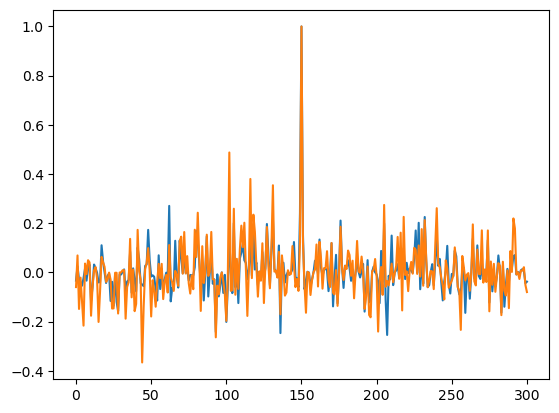

In [7]:
a, stats  = X.quick_analyze()
plt.plot(a[0])
plt.plot(a[1])